In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_swiss_roll
import DiffusionModel as DM
import torch.optim as optim
import seaborn as sns
import torch.nn as nn
from celluloid import Camera
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
x1, color = make_swiss_roll(n_samples=10000, noise=0.0, random_state=None, hole=False)

x1

array([[-9.4772941 ,  8.31467597, -0.9962824 ],
       [ 2.8048025 , 13.99092042, 13.64929687],
       [-3.51444808, 20.2903482 ,  7.51002995],
       ...,
       [ 6.08867919, 18.90409791, -0.83912717],
       [-9.35889095,  7.41306491,  0.49477417],
       [-3.51683225, 13.09481067,  7.50924562]])

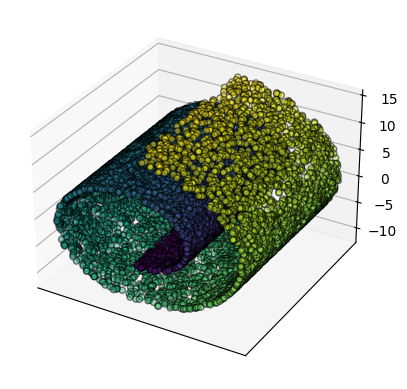

In [9]:
X = torch.tensor(x1, dtype=torch.float32)

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1[:, 0], x1[:, 1], x1[:, 2], marker='o', alpha=0.5, c=color,  edgecolor='black')  # Adjust color and marker as needed
#plt.title(r"Initial distribution $q(x_0)$")
plt.xticks([])
plt.yticks([])

plt.show()

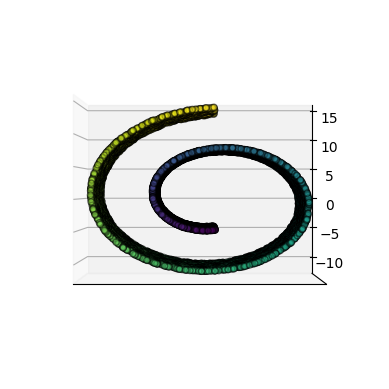

In [8]:
# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1[:, 0], x1[:, 1], x1[:, 2], marker='o', alpha=0.5, c=color,  edgecolor='black')  # Adjust color and marker as needed
#plt.title(r"Initial distribution $q(x_0)$")
plt.xticks([])
plt.yticks([])
ax.view_init(0, 90) 
  
plt.show()

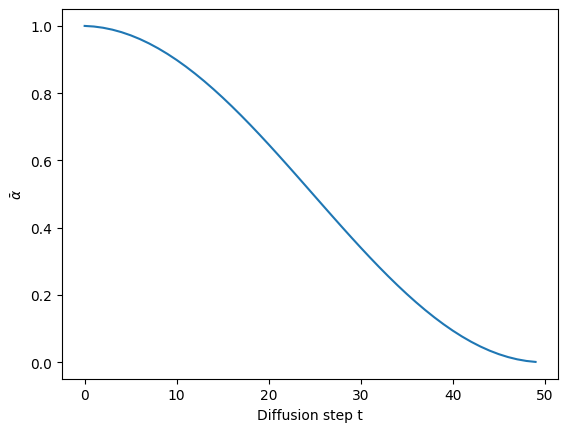

In [11]:
diffusion_steps = 50

# Parámetros definidos de acuerdo al paper de Nichol & Dariwal (https://arxiv.org/pdf/2102.09672.pdf)
# Con el objetivo de optimizar el proceso de aprendizaje.
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

In [12]:
def diffuse(Xbatch, t):
    epsilon = torch.randn(size=Xbatch.shape)
    #.repeat to transform baralphas to adequate dimension: a vector of same size as Xbatch:
    diffused = np.sqrt(baralphas[t]).repeat(1,Xbatch.shape[1]) * Xbatch + (np.sqrt(1-baralphas[t])).repeat(1,Xbatch.shape[1]) * epsilon
    return diffused, epsilon

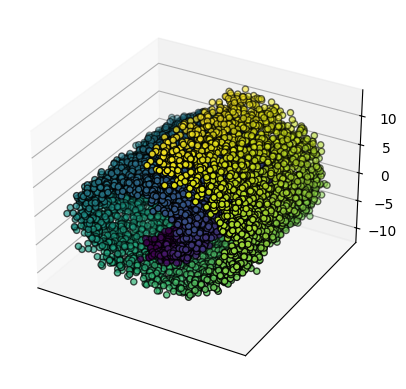

In [33]:
t = 7

diffused, epsilon = diffuse(X, torch.full([len(X), 1], fill_value=20))

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(diffused[:, 0], diffused[:, 1], diffused[:, 2], c=color, marker='o',  edgecolor='black')  # Adjust color and marker as needed

#plt.title(r"Equilibrium Distribution $q(x_T)$")
plt.xticks([])
plt.yticks([])

plt.show()

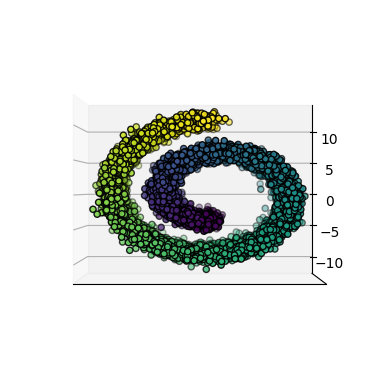

In [34]:
t = 7

diffused, epsilon = diffuse(X, torch.full([len(X), 1], fill_value=20))

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(diffused[:, 0], diffused[:, 1], diffused[:, 2], c=color, marker='o',  edgecolor='black')  # Adjust color and marker as needed

#plt.title(r"Equilibrium Distribution $q(x_T)$")
plt.xticks([])
plt.yticks([])

ax.view_init(0, 90) 

plt.show()

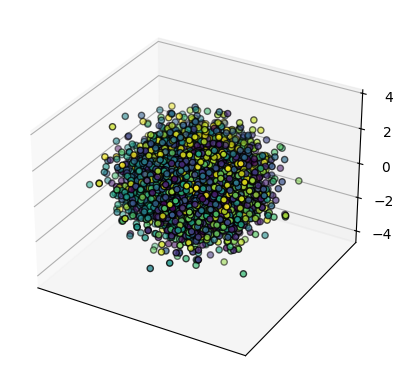

In [36]:
t = 30

diffused, epsilon = diffuse(X, torch.full([len(X), 1], fill_value=49))

# Creating a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(diffused[:, 0], diffused[:, 1], diffused[:, 2], c=color, marker='o',  edgecolor='black')  # Adjust color and marker as needed

#plt.title(r"Equilibrium Distribution $q(x_T)$")
plt.xticks([])
plt.yticks([])

plt.show()

In [14]:
model = DM.DiffusionModel(nInputs=3, nLayers=5)

device = "cuda"
model = model.to(device)

model

DiffusionModel(
  (inputBlock): Linear(in_features=4, out_features=64, bias=True)
  (diffLayers): ModuleList(
    (0-4): 5 x DiffusionLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (outputBlock): Linear(in_features=64, out_features=3, bias=True)
)

In [19]:
nepochs = 800
batch_size = 2048

# Loss Function is MSE
loss_fn = nn.MSELoss()
# Adam Optimizer, this is the gradient descent method
optimizer = optim.Adam(model.parameters(), lr=0.001)
# LR Schedule
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)

for epoch in range(nepochs):
    epoch_loss = steps = 0  # Initialize epoch's loss

    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size] # Takes a Portion of particles from the complete X particles set
        timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1]) # Samples random t
        noised, eps = diffuse(Xbatch, timesteps) # Returns a noised Xbatch and the corresponding noises (epsilons)
        predicted_noise = model(noised.to(device), timesteps.to(device)) # Makes the model predict noise, given the current weights
        loss = loss_fn(predicted_noise, eps.to(device)) # Loss of the computation. Compares predicted eps to real eps
        optimizer.zero_grad() # Sets to zero all grads before backpropagating
        loss.backward() # Backpropagates the gradient of the loss function
        optimizer.step() # Performs a single optimization step (parameter update).
        epoch_loss += loss
        steps += 1
    print(f"Epoch {epoch} loss = {epoch_loss / steps}")

Epoch 0 loss = 1.662203073501587
Epoch 1 loss = 1.2712478637695312
Epoch 2 loss = 1.0431431531906128
Epoch 3 loss = 1.001589059829712
Epoch 4 loss = 0.9803432822227478
Epoch 5 loss = 0.9770933985710144
Epoch 6 loss = 0.9747991561889648
Epoch 7 loss = 0.9585289359092712
Epoch 8 loss = 0.9438363909721375
Epoch 9 loss = 0.9405708312988281
Epoch 10 loss = 0.9334580302238464
Epoch 11 loss = 0.9289647936820984
Epoch 12 loss = 0.9246689677238464
Epoch 13 loss = 0.9390015006065369
Epoch 14 loss = 0.9301993250846863
Epoch 15 loss = 0.9164718985557556
Epoch 16 loss = 0.9323938488960266
Epoch 17 loss = 0.907868504524231
Epoch 18 loss = 0.9103745818138123
Epoch 19 loss = 0.9175357222557068
Epoch 20 loss = 0.9181199073791504
Epoch 21 loss = 0.9199144244194031
Epoch 22 loss = 0.9023227691650391
Epoch 23 loss = 0.9175419807434082
Epoch 24 loss = 0.9098631739616394
Epoch 25 loss = 0.9175718426704407
Epoch 26 loss = 0.9002666473388672
Epoch 27 loss = 0.9071061015129089
Epoch 28 loss = 0.903514564037323

In [20]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad(): # Context-manager that disables gradient calculation.
        x = torch.randn(size=(nsamples, nfeatures)).to(device) # Generation of random noise distribution Data positions. nfeatures = Problem Dimensionality
        xt = [x] # x to list?
        # Sampling Loop
        for t in range(diffusion_steps-1, 0, -1): # Reverse Diffusion time Schedule
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device)) # Predicts noise for all x, given currently at time t
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise) # DETERMINISTIC Reverse Diffusion Step
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device) # NOW, add RANDOM noise
            xt += [x]

        return x, xt

In [21]:
Xgen, Xgen_hist = sample_ddpm(model, 2000, 3)
Xgen = Xgen.cpu()

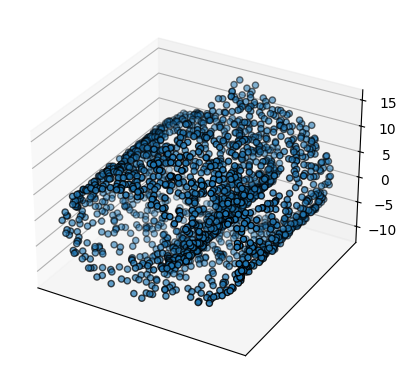

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Xgen[:, 0], Xgen[:, 1], Xgen[:,2], c='#1f77b4', marker='o',  edgecolor='black')  # Adjust color and marker as needed
#plt.title(r"Parametrized $p_\theta(x_0)$")
plt.xticks([])
plt.yticks([])

  
plt.show()

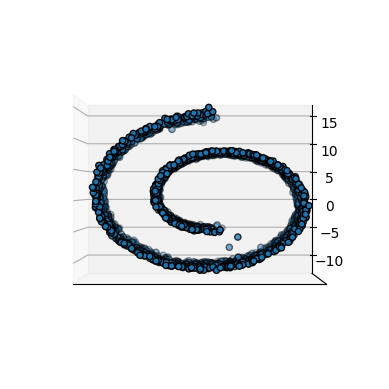

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(Xgen[:, 0], Xgen[:, 1], Xgen[:,2], c='#1f77b4', marker='o',  edgecolor='black')  # Adjust color and marker as needed
#plt.title(r"Parametrized $p_\theta(x_0)$")
plt.xticks([])
plt.yticks([])
ax.view_init(0, 90) 
  
plt.show()
